# Решение домашнего задания #5

Для решения будем использовать Mamba модель из простой имплементации на торче (https://github.com/myscience/mamba), однако немного упрощена для большей компактности.

### Базовая настройка

In [12]:
import torch
from torch.utils.data import DataLoader
from mambapy.lm import LM, MambaConfig

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

import pandas as pd

from matplotlib import pyplot as plt


from einops import rearrange
from torch.nn.functional import cross_entropy
import seaborn as sns

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
TARGET_ROW = "To prove that"

In [ ]:
config = MambaConfig(
    n_layers=12,
    d_model=64,
    d_state=64,
    d_conv=12,
)

### Загрузка датасета (датасет латеховских статей) и токенайзера (токенайзер GPT-2)

In [5]:
train_ds = pd.concat([pd.read_parquet(f'../../data/proof-pile/000{i}.parquet') for i in range(3)], ignore_index=True)
text_data = train_ds['text'].tolist()

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

1

### Теперь нам нужен кастомный лоадер для тренировки

In [7]:
class CustomLoader(DataLoader):
    def __init__(self, texts, tokenizer, loader_size=16, batch_size=16, block_size=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.block_size = block_size
        self.loader_size = loader_size

        self.text_id = -self.loader_size
        self.page_tokens = None
        self.page_training_pairs = None

        self.next_page()

        super().__init__(self, batch_size=batch_size)

    def next_page(self):
        self.text_id += self.loader_size
        if self.text_id + self.loader_size > len(self.texts):
            self.text_id = 0
        self.page_tokens = [
            self.tokenizer.encode(self.texts[self.text_id + i])
            for i in range(self.loader_size)
        ]
        self.page_training_pairs = torch.tensor([
            [
                tokens[i:i + self.block_size],
                tokens[i + 1:i + self.block_size + 1]
            ]
            for tokens in self.page_tokens
            for i in range(0, len(tokens) - self.block_size)
        ])
        self.page_training_pairs = self.page_training_pairs[torch.randperm(len(self.page_training_pairs))]

    def __iter__(self):
        for i in range(0, len(self.page_training_pairs), self.batch_size * 30):
            yield self.page_training_pairs[i:i + self.batch_size, 0, :], self.page_training_pairs[i:i + self.batch_size, 1, :]

    def __len__(self):
        return len(self.page_training_pairs) // self.batch_size // 30

### Теперь мы готовы к обучению

In [8]:
dl = CustomLoader(text_data, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (7399 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
class LightningMamba(LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.model = LM(config, vocab_size=50304)
        self.tokenizer = tokenizer

        self.loss_history = []

    def forward(self, idx):
        logits = self.model(idx)
        return logits
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        idx, targets = batch

        pred = self(idx)

        pred = rearrange(pred, 'b s v -> (b s) v')
        targets = rearrange(targets, 'b s -> (b s)')
        
        loss = cross_entropy(pred, targets)
        
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.loss_history.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        seg_generator = self.model.generate(
            prompt=TARGET_ROW,
            tokenizer=self.tokenizer,
            num_tokens=10,
            top_k=10
        )
        generated_text = "".join([seg[0] for seg in seg_generator])
        print('test/generated_text', generated_text)
        
        return super().on_train_epoch_start()
    
    def on_train_epoch_end(self):
        dl.next_page()

        return super().on_train_epoch_end()

In [10]:
model = LightningMamba(config, tokenizer)

In [11]:
trainer = Trainer(
    max_epochs=10,
    accelerator="cuda",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LM   | 7.1 M  | train
---------------------------------------
7.1 M     Trainable params
0         Non-trainable params
7.1 M     Total params
28.260    Total estimated model params size (MB)
102       Modules in train mode
0         Modules in eval mode
/home/setday/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 1:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=5.800, train/loss_epoch=7.740]          test/generated_text To prove that\n$ ofnn} \
}
Epoch 2:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=4.210, train/loss_epoch=5.350]          test/generated_text To prove that, $\mu
(\end{\in
Epoch 3:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=3.500, train/loss_epoch=4.250]          test/generated_text To prove that $0\right)$.
\begin{
Epoch 9:   0%|          | 0/250 [00:00<?, ?it/s, train/loss_step=4.230, train/loss_epoch=4.550]         test/generated_text To prove that a
\begin{enumerate} \
Epoch 9: 100%|██████████| 250/250 [01:09<00:00,  3.58it/s, train/loss_step=3.580, train/loss_epoch=3.960]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [01:14<00:00,  3.36it/s, train/loss_step=3.580, train/loss_epoch=3.960]


<Axes: >

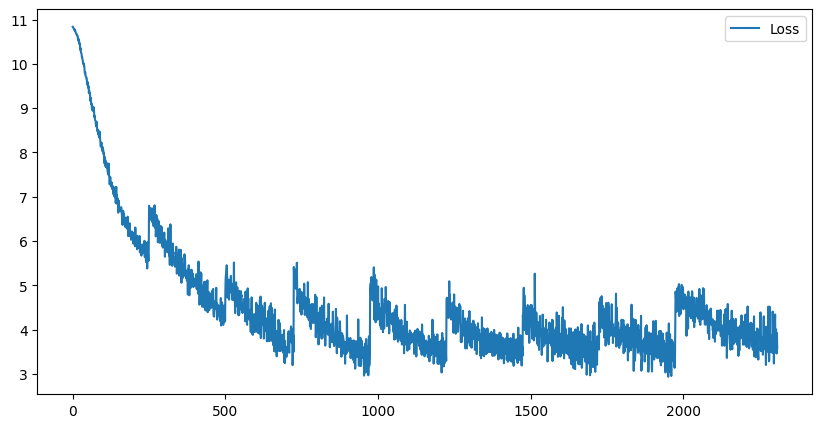

In [13]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Loss')

### Смотрим, что же получилось

_предварительно откатываем модель до 3-ей эпохи_

In [15]:
generated_text = "".join([tok[0] for tok in model.model.generate(
    prompt=TARGET_ROW,
    tokenizer=tokenizer,
    num_tokens=300,
    top_k=10
)])
print('test/generated_text', generated_text)

test/generated_text To prove that $C^{n+1}$ for $\mathbf{X}_p$,
\begin{equation*}\label{c:1}
\frac{1}{\mathbf{\bar\lambda}^2)^{-1}1^{*-1+1+k}{4}^\sum_{i=0}^2(x+\mathbf{1}\frac{2\frac{t+\frac\int_{\sigma^{-1}=\math}^\in[0,\infty)$, which is the $d$ be a single case, the same $k^\eta\in \tilde\rfloor^2$ with $t$ are not a constant $\theta$, we have that
 \subsection{\bf\|\rho^t\(\mathbf{x+2}\|_{\tau}\|\R^2\right)\|^1(t\|_{\Ls}{t}\int_{\sigma^\infty}+\sigma(x+q+\frac{\frac{2}{1})=\frac{1}{4}(\eta_\E}+\right)^\right,\|\hat \R^\le \|\alpha\||\x\|\Lr^{1-\mathcal{B}}(X)}{


In [16]:
def plot_weights(weights, title='Attention Weights'):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(weights.shape[0]):
        sns.heatmap(weights[i].detach().cpu().numpy(), ax=ax[i // 4][i % 4], square=True)
        ax[i // 4][i % 4].set_title(f'Head {i+1}')
        ax[i // 4][i % 4].axis('off')

    plt.tight_layout()
    plt.show()